<a href="https://colab.research.google.com/github/patriciamedyna/Classifier_page/blob/main/Tobacco_without_tags.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! [ -e /content ] && pip install -Uqq fastai

In [2]:
#hide
!pip install -Uqq fastbook
import fastbook

In [3]:
#hide
from fastbook import *
from IPython.display import display,HTML

In [4]:
from fastai.basics import *
from fastai.text.core import *
from fastai.text.data import *
from fastai.text.models.core import *
from fastai.text.models.awdlstm import *
from fastai.callback.rnn import *
from fastai.callback.progress import *
from fastai.vision import *
from fastai.text.all import *
from fastai.text import *
from datetime import datetime

In [5]:
seed = 42

# python RNG
import random
random.seed(seed)

# pytorch RNGs
import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

# numpy RNG
import numpy as np
np.random.seed(seed)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
path = '/content/drive/MyDrive/Colab Notebooks/Datasets/Tobacco_LSTM/layout/'

In [8]:
df_train = pd.read_csv(path + 'train_tags.csv', delimiter=',',  error_bad_lines=False, index_col=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
df_train = df_train.drop(columns=['docid','binder','text_tags'])
df_train.head(1)

,class,text
0,FirstPage,"Dr. M.A. Manzelli, PHILIP MORRIS INC., Research Center, P.O. Box 3 D Richmond, Va. 23206 U.S.A. Dear Art, Please find enclosed a proposed program for your visit in Europe. As you will see, this program contains two major points: a) A two-days meeting in Neuchätel with all people in Europe involved in infestation control (proposed program included). b) Visit of all PM Europe production centers with the purpose of: - training people in Charge of the insect indenti-fication - inspection of the sanitary conditions One of our main problems is the insect Identification and ..."


In [10]:
#path = '/content/drive/MyDrive/Colab Notebooks/Tobacco_LSTM/layout/'
df_test = pd.read_csv(path + 'test_tags.csv', delimiter=',', error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
df_test = df_test.drop(columns=['docid','binder','text_tags'])
df_test.head(1)

,class,text
0,FirstPage,"rii.E ^litl' karg;; , 1980 ■'!?.!r- ■ !T |Sf: .'■■ J -1 p '■Mr'"" trr*. my MAILLARD REACTION ""A"" FLAVOR COMPONENTS./ A ] 5 6 *! •• f ----------------------------------------- ! i f i wii'.ii ■. , . j i i F; tp...' t/ t-■ l. ■i. v.' i -!* .i■ uill .,0'; [o,.' ' ’. Identification of flavor components in the ütjiieous la..."


In [12]:
df_train.shape, df_test.shape

((1031, 2), (259, 2))

In [13]:
#unsup_tags = pd.read_csv(path + 'unsup_tags.csv', delimiter=',', error_bad_lines=False)

## Create DataLoader

In [14]:
def get_features(r):

  return r['text']

def get_labels(r):

  return r['class']

In [15]:
dblock_train = DataBlock(
    blocks=(TextBlock.from_df(text_cols=['text', 'class'], seq_len=72), CategoryBlock),
            get_x=get_features, 
            get_y=get_labels)

dloader_train = dblock_train.dataloaders(df_train, bs=128)
dloader_train.show_batch(max_n=2)

,text,category
0,"xxbos xxfld 1 xxup u ) ö tn t ; ( fi a « o ri o o u xxmaj lj o ü - ] ■ xxup vd ( ji rl xxunk < u o p cj o i m i y 4j o ■ h f i xxmaj hl < ; < h o 4 > si tu o m xxup xxunk , | > xxunk fl tj * xxmaj xxunk o o n fi xxup xxunk ri tj o fl to ö » * * o to * fi « 1 < l > -h > « 3 e > p xxunk rh ft 4j xxmaj fh m | > o / ■ > 0 xxunk rj 0 < 9 , ri xxup hj < i > o xxup cd < il it . 5 xxunk xxup cj xxmaj pi fh j • tn d xxmaj vi *",NextPage
1,"xxbos xxfld 1 xxunk xxmaj federal xxmaj register / xxmaj vol . 45 . xxmaj no . 7 l xxmaj xxunk . xxmaj xxunk 10 , xxunk / xxmaj xxunk xxmaj tb 1 ml xxunk 1 xxmaj xxunk xxunk - xxunk xxup xxunk ) , « ! ( xxunk xxmaj xxunk » sf xxmaj xxunk xxunk xxmaj xxunk l c ta xxmaj xxunk # tm xxup mh « far .. . ti 10 xxmaj xxunk xxunk » - « or … … .. ■ . xxrep 3 - * * "" 3 w * . » xxunk . 1 0 « xxmaj xxunk . xxrep 4 - - xxmaj xxunk xxunk xxmaj mt * … … .. » 0 « xxunk … xxunk : f 01 ■ mt xxmaj xxunk i 04 xxunk - - xxmaj xxunk xxmaj al ! » * 5 04 xxunk xxup ta » xxunk xxrep",NextPage


## Classification Model

In [16]:
# checkpoint 
cbs=[SaveModelCallback()]

In [17]:
now = datetime.today().strftime('%Y-%m-%d-%H:%M:%S')

In [18]:
learn = text_classifier_learner(dloader_train, AWD_LSTM, drop_mult=0.5,path='/content/drive/MyDrive/Colab Notebooks/Datasets/Tobacco_LSTM/layout/checkpoints', metrics=[error_rate, accuracy, Perplexity()]).to_fp16()

In [19]:
learn.fine_tune(12, 1e-2, cbs=cbs)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,0.722715,0.628820,0.378641,0.621359,1.875397,00:03


Better model found at epoch 0 with valid_loss value: 0.6288201808929443.


epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,0.541454,0.580386,0.354369,0.645631,1.786729,00:07
1,0.500401,0.545736,0.330097,0.669903,1.725879,00:07
2,0.463981,0.435905,0.213592,0.786408,1.546362,00:07
3,0.438705,0.436106,0.237864,0.762136,1.546672,00:07
4,0.408872,0.299150,0.131068,0.868932,1.348711,00:07
5,0.378998,0.267673,0.097087,0.902913,1.306919,00:07
6,0.354262,0.222595,0.067961,0.932039,1.249315,00:07
7,0.326817,0.210506,0.058252,0.941748,1.234302,00:07
8,0.305065,0.208930,0.063107,0.936893,1.232359,00:07
9,0.288241,0.205783,0.053398,0.946602,1.228487,00:07


Better model found at epoch 0 with valid_loss value: 0.5803862810134888.
Better model found at epoch 1 with valid_loss value: 0.5457364320755005.
Better model found at epoch 2 with valid_loss value: 0.4359048008918762.
Better model found at epoch 4 with valid_loss value: 0.2991495430469513.
Better model found at epoch 5 with valid_loss value: 0.2676728069782257.
Better model found at epoch 6 with valid_loss value: 0.2225954383611679.
Better model found at epoch 7 with valid_loss value: 0.2105059027671814.
Better model found at epoch 8 with valid_loss value: 0.20893020927906036.
Better model found at epoch 9 with valid_loss value: 0.205783411860466.
Better model found at epoch 10 with valid_loss value: 0.20412535965442657.
Better model found at epoch 11 with valid_loss value: 0.20310340821743011.


In [20]:
#learn.fine_tune(10, 1e-2,cbs=cbs)

In [21]:
learn.show_results()

,text,category,category_
0,"xxbos xxfld 1 xxunk xxmaj federal xxmaj register i xxmaj vol . < 5 . xxmaj no . 7 / xxmaj xxunk . xxmaj xxunk 10 , xxunk / xxmaj xxunk ( b ) xxmaj whether each » xxunk bat xxunk xxunk of xxunk group . 2 . xxmaj to xxunk xxunk xxunk to the • xxunk of xxup po ) to xxunk the needs of xxunk proposed xxunk area : ( a ) xxmaj whether the xxunk ! xxunk xxunk of agriculture and labor in xxunk - xxunk « . xxmaj xxunk ; ( b ] xxmaj whether the xxunk xxunk xxunk xxmaj problems xxunk of xxmaj ms xxmaj community of xxunk . j xxmaj to determine « xxunk xxmaj xxunk xxmaj xxunk - xxunk xxmaj is xxunk xxunk lo xxunk and xxmaj operate the proposed xxunk , 4- xxmaj to determine whether xxunk xxmaj broadcasting xxmaj inc .",NextPage,FirstPage
1,"xxbos xxfld 1 xxunk rightfax xxup xxunk xxup company : xxup martin lipton xxunk xxup m. xxup xxunk xxup xxunk ti - xxunk xxunk xxunk xxup w - xxunk xxmaj richard u , xxunk xxup douglas xxup s. t , xxunk xxup m. xxup xxunk xxup xxunk xxup j. xxup fortgang xxunk , ff xxup c. xxup xxunk xxup michael xxup w. xxunk xxup xxunk xxup a. xxup martin xxunk xxup a. xxunk xxup lawrence 0- xxup xxunk xxunk - f rt , xxunk xxup paul xxup xxunk . xxup jr . xxunk xxup c. xxup xxunk xxup harold xxup s. xxunk xxup david xxup m. xxup einhorn xxunk xxup c. xxup xxunk t xxunk ö. xxup kqplow xxup theodore xxup n > xxup xxunk 's £ pw xxup aro □ . xxup xxunk xxup xxunk xxup o , xxup feintuch xxunk a. xxunk xxunk > c xxup m. »",FirstPage,FirstPage
2,"xxbos xxfld 1 i xxunk xxunk xxup herbert xxup m. xxup wachtell xxup theodore xxup gewertz xxup bernard xxup w. xxup nussbaum xxup richard xxup o. xxup xxunk xxup douglas xxup s. xxup xxunk xxup steven xxup m * xxup bar xxup na xxup chaim xxup j * xxup fortgang xxup peter xxup c * xxup canellos xxup michael xxup w * xxunk xxup allan xxup a. xxup martin xxup barry xxup a. xxunk xxup lawrence xxup b- xxup xxunk xxup robert xxup b. xxup mazur xxup paul xxunk , xxmaj jfl . xxup peter xxup c. xxup hein xxup harold 5 . xxup xxunk xxup david xxup m * xxup einhorn xxup xxunk xxup b , xxup forrest xxup meyer xxup g. xxup koplow xxup theodore xxup n * xxup xxunk xxup edward xxup d * xxup xxunk xxup richard xxup d. xxunk xxup daniel xxup a. xxup neff",FirstPage,FirstPage
3,"xxbos xxfld 1 02 / 24 / 99 11:29 xxunk xxup lipton xxunk xxup xxunk xxup in xxup lipton xxup herbert xxup m. xxup wachte . xxup ll xxunk xxunk * xxup bernard w , xxup xxunk « xxup richard xxup d. xxup kat xxup cmc n xxup xxunk xxup e , xxunk xxup steven xxup m , « ar xxup na xxup xxunk xxup j. xxunk xxunk xxup c. canellos xxup michael w. xxup xxunk xxup allah xxup a- xxup martin » xxunk xxup a. xxunk » xxmaj lawrence b. xxunk xxup robert 8 , xxup xxunk » aul xxup xxunk xxup xxunk , xxup jr . xxup peter xxup c. xxup hein xxup xxunk xxup s. xxup xxunk xxup oaviq xxup m. xxup einhorn xxup xxunk * ■ xxup xxunk t xxunk xxup o * xxunk xxup xxunk » xxup n. xxup mi « vi 's xxup edward",FirstPage,FirstPage
4,"xxbos xxfld 1 xxup wlrk rightfax xxmaj server 5 / 28 / 99 5:12 : xxup page xxunk / 6 xxmaj xxunk xxmaj wilson company : lorillard xxmaj tobacco xxmaj company rightfax xxup xxunk tl > ton xxup m. xxup xxunk xxup xxunk xxunk xxunk w * xxunk xxunk xxup d. xxunk xxup xxunk 5 . xxup xxunk xxup steven xxup m * . xxup bar xxup na xxunk £ xxup fortgang xxup pe xxup ter xxup c , xxunk xxunk . w » xxunk xxmaj allah a « xxunk xxunk a ! xxunk xxunk ■ - xxunk xxunk # xxunk xxup hai xxunk xxup paul xxunk , xxup jr . xxup peter xxunk xxup xxunk xxunk david % xxup einhorn xxunk . xxunk xxunk xxunk xxup xxunk xxrep 3 o xxup xxunk xxup n. xxup xxunk xxup edward □ . xxunk xxmaj richard o- xxunk xxunk xxup a. xxup",FirstPage,FirstPage
5,"xxbos xxfld 1 xxunk xxmaj sudol , xxmaj marius 129 - 68 - 8626 9 . xxup supporting xxup data , xxup research xxup plan . xxmaj do not attach more than six additional pages ( xxunk ) . xxmaj please note that this page limit includes xxup figures and xxup references . xxup background xxmaj t

In [22]:
learn.save('model_'+ now)

Path('/content/drive/MyDrive/Colab Notebooks/Datasets/Tobacco_LSTM/layout/checkpoints/models/model_2022-03-31-02:24:38.pth')

In [23]:
# load model
learn = learn.load('model_'+ now)

SuggestedLRs(valley=0.0005754399462603033)

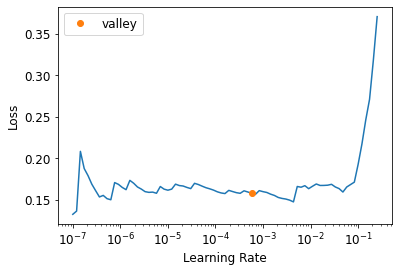

In [24]:
learn.unfreeze()
learn.lr_find()

In [25]:
learn_lm = text_classifier_learner(dloader_train, AWD_LSTM, drop_mult=0.5,metrics=[error_rate, accuracy, Perplexity()]).to_fp16()

In [26]:
learn_lm.fine_tune(10, 1e-2,cbs=cbs)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,0.704926,0.609052,0.378641,0.621359,1.838688,00:03


Better model found at epoch 0 with valid_loss value: 0.6090522408485413.


epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,0.570234,0.561196,0.334951,0.665049,1.752767,00:07
1,0.516739,0.503065,0.300971,0.699029,1.653782,00:07
2,0.485633,0.435703,0.233010,0.766990,1.546050,00:07
3,0.452371,0.357725,0.145631,0.854369,1.430072,00:07
4,0.415011,0.343251,0.131068,0.868932,1.409523,00:07
5,0.380371,0.286331,0.131068,0.868932,1.331534,00:07
6,0.350612,0.264594,0.106796,0.893204,1.302902,00:07
7,0.329162,0.276060,0.097087,0.902913,1.317927,00:07
8,0.303431,0.263156,0.092233,0.907767,1.301030,00:07
9,0.282633,0.260109,0.082524,0.917476,1.297071,00:07


Better model found at epoch 0 with valid_loss value: 0.5611956119537354.
Better model found at epoch 1 with valid_loss value: 0.5030645132064819.
Better model found at epoch 2 with valid_loss value: 0.4357030987739563.
Better model found at epoch 3 with valid_loss value: 0.35772475600242615.
Better model found at epoch 4 with valid_loss value: 0.34325113892555237.
Better model found at epoch 5 with valid_loss value: 0.2863313853740692.
Better model found at epoch 6 with valid_loss value: 0.26459380984306335.
Better model found at epoch 8 with valid_loss value: 0.2631559371948242.
Better model found at epoch 9 with valid_loss value: 0.26010897755622864.


##Validation

In [27]:
# create dataloader of test
dblock_test = DataBlock(
    blocks=(TextBlock.from_df('text', seq_len=72), CategoryBlock),
            get_x=get_features, 
            get_y=get_labels)

dloader_test = dblock_test.dataloaders(df_test, bs=128)

In [28]:
test_dl = dloader_test.test_dl(df_test['text'])
preds = learn.get_preds(dl=test_dl, with_decoded=True)

In [29]:
len(preds)

3

(#4) [0.20310340821743011,0.05339805781841278,0.946601927280426,1.2251991033554077]

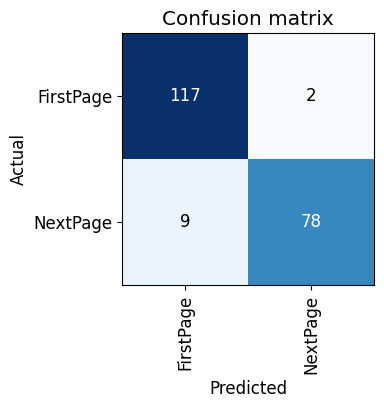

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4), dpi=100)
learn.validate()

In [31]:
test_dl_lm = dloader_test.test_dl(df_test['text'])
preds_lm = learn_lm.get_preds(dl=test_dl_lm, with_decoded=True)

(#4) [0.26010897755622864,0.08252426981925964,0.917475700378418,1.2970714569091797]

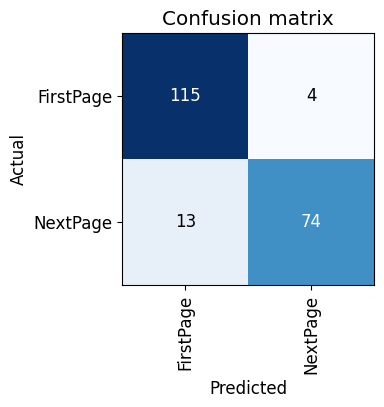

In [32]:
interp_lm = ClassificationInterpretation.from_learner(learn_lm)
interp_lm.plot_confusion_matrix(figsize=(4,4), dpi=100)
learn_lm.validate()

In [33]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-2,cbs=cbs)

epoch,train_loss,valid_loss,error_rate,accuracy,perplexity,time
0,0.328810,0.905689,0.359223,0.640777,2.473637,00:07
1,0.361934,0.132823,0.067961,0.932039,1.142047,00:07
2,0.275297,0.081051,0.019417,0.980583,1.084426,00:07
3,0.217345,0.068461,0.024272,0.975728,1.070859,00:07
4,0.179104,0.073904,0.029126,0.970874,1.076704,00:07


Better model found at epoch 0 with valid_loss value: 0.9056894779205322.
Better model found at epoch 1 with valid_loss value: 0.132822647690773.
Better model found at epoch 2 with valid_loss value: 0.08105064183473587.
Better model found at epoch 3 with valid_loss value: 0.06846137344837189.


In [34]:
test_dl = dloader_test.test_dl(df_test['text'])
preds = learn.get_preds(dl=test_dl, with_decoded=True)

(#4) [0.06846137344837189,0.024271832779049873,0.9757281541824341,1.0708593130111694]

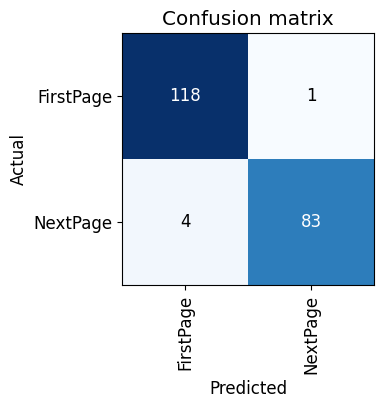

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4), dpi=100)
learn.validate()